[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        mask = masks[i]
        color = np.array(matplotlib.colors.to_rgb(colormap.colors[labels[i]]))*255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        image = cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=1)
    display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_adaptive", verbose=False):
    if verbose:
        print("Using mode '%s'." % mode)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    # We are also deliberately not sharpening here
    if params['canny_unmasking']:
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, 40, 180)
        canny_filled = apply_imfill(apply_closure(canny, 5))
    
    if params['invert_image']:
        image = 255 - image

    if params['denoise_pre']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params['contrast']:
        if verbose:
            print(("Enhancing contrast by factor of %.2f, with "
                   "offset=%s and preserve_background=%s.") %
                  (params['contrast'], params['offset'], params['preserve_background']))
        image = apply_contrast(image, params['contrast'],
                               params['offset'], params['preserve_background'])
    
    if params['clipLimit']:
        if verbose:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params['denoise_post']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbose:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbose:
            print("Applying Canny with thresholds %i and %i." %
                  (params['canny_thresh1'], params['canny_thresh2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['canny_thresh1'], params['canny_thresh2'])
    elif mode == "edge_sobel":
        if verbose:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbose:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbose:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_manual":
        if verbose:
            print("Manually thresholding on values >=%i." % params['manual_threshold'])
        binarized = np.uint8(image >= params['manual_threshold'])
    elif mode == "thresh_otsu":
        if verbose:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    if params['size_thresh']:
        if verbose:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params['canny_unmasking']:
        if verbose:
            print("Unmasking areas without edges using Canny(40, 180):")
        binarized = binarized & canny_filled
    
    if verbose:
        print("Closing with kernel size of %i." % params['closure_ks'])
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [4]:
mode = "thresh_manual"

params = {
    ##################################################
    ###### PREPROCESSING #############################
    ### set to 0 to disable ##########################
    
    'invert_image': True,

    'denoise_pre': 3,
    
    # background separation
    'contrast': 100,  # contrast boosting factor
    'offset': -1,  # manually +/- more background
    'preserve_background': False,

    # histogram equalization
    'clipLimit': 0,  # contrast limit for clipping
    
    'denoise_post': 0,

    ##################################################

    ##################################################
    ###### BINARIZATION MODE #########################
    ### set `mode` to one of the following ###########
    ### other params will be ignored* ################

    # "background_filter"
    'lower_width': 10,  # distances from peak
    'upper_width': 10,
    
    # "edge_canny"
    'canny_thresh1': 30,  # lower values are ignored
    'canny_thresh2': 210, # middle values considered if
                       # connected to upper values
    
    # "edge_sobel"
    'sobel_ks': 5,
    
    # "kmeans"
    'attempts': 10,  # number of times to repeat
    
    # "thresh_adaptive"
    'thresh_ks': 151,
    'C': 8,
    
    # "thresh_otsu"
    # No params needed
    
    # "thresh_manual"
    'manual_threshold': 1,

    ##################################################
    
    # size threshold
    'size_thresh': 25,
    
    # unmask areas without edges
    # uses 'threshold1' and 'threshold2' above
    'canny_unmasking': True,
    
    # image closure kernel size
    'closure_ks': 2,
}

# Fit and classify on control image

## Create mask image and extract raw features

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 100.00, with offset=-1 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking regions smaller than 25 pixels.
Unmasking areas without edges using Canny(40, 180):
Closing with kernel size of 2.


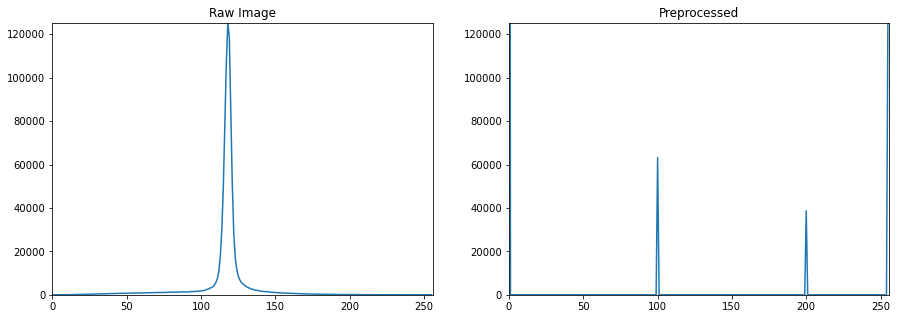

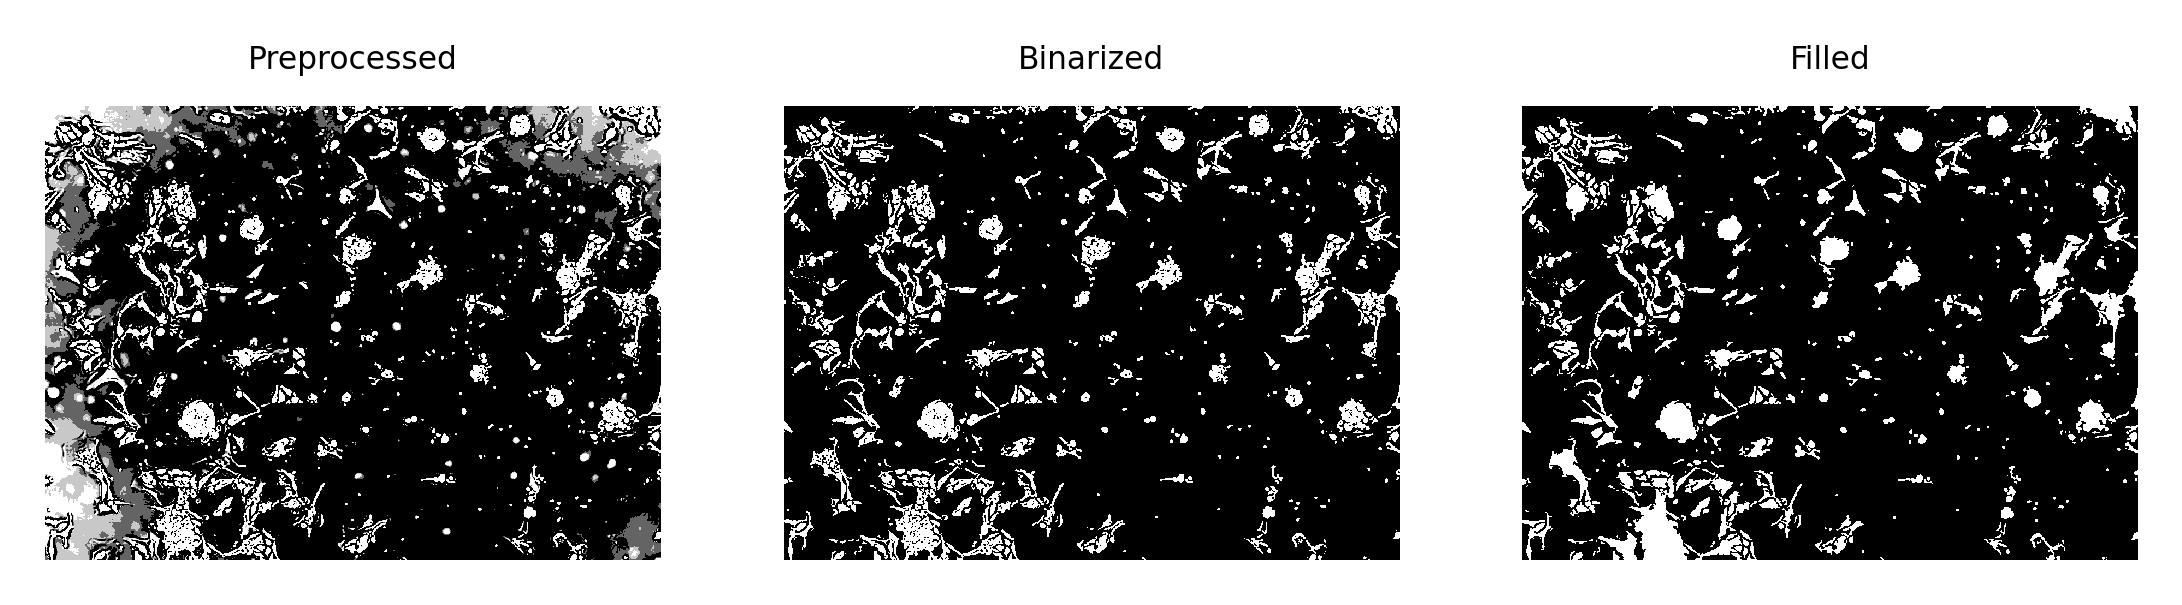

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
396 10                      0.595176                         27.240977   
450 5                       0.650909                         28.973409   
476 4                       0.544450                         19.566584   
542 14                      0.497983                         33.192404   
576 4                       0.443737                         25.836452   
...                              ...                               ...   
396 810                     0.762772                         13.750437   
408 816                     0.506184                         17.478811   
170 825                     0.619204                         18.470431   
101 824                     0.545036                         21.045655   
393 824                     0.447168                         20.741870   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
396 10                 26.30589287593181                        143.5   
450 5                 29.410882339705484                        228.5   
476 4                 22.360679774997898                        146.5   
542 14                 31.38470965295043                        355.5   
576 4                 26.476404589747453                        217.5   
...                                  ...                          ...   
396 810               14.422205101855956                        106.5   
408 816                 19.1049731745428                        112.5   
170 825                19.72308292331602                        144.5   
101 824                22.80350850198276                        185.5   
393 824               22.825424421026653                        118.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
396 10                          16.213163          85.45584412271573   
450 5                           18.859052         108.76955262170063   
476 4                           10.653036         58.627416997969476   
542 14                          16.529261          91.59797974644673   
576 4                           11.464602          71.21320343559644   
...                                   ...                        ...   
396 810                         10.488454         41.798989873223306   
408 816                          8.847494         49.455844122715675   
170 825                         11.436958          52.97056274847712   
101 824                         11.470635         57.455844122715675   
393 824                          9.275108         61.455844122715675   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
396 10                      0.5955111088690992                          144.0   
450 5                       0.4760155475785585                          229.0   
476 4                      0.40018714674381894                          147.0   
542 14                      0.2576595773458417                          356.0   
576 4                       0.3274170272900986                          218.0   
...                                        ...                            ...   
396 810                     0.3924787781523315                          107.0   
408 816                     0.4396075033130282                          113.0   
170 825                    0.36657828891679667                          145.0   
101 824                     0.3097350087477934                          186.0   
393 824                     0.5186147183351534                          119.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [5]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [6]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1             2            3          4   \
x   y                                                                       
396 10  -6.675887e+06 -16732.440538 -10985.411960 -1400.014264 -15.445618   
450 5   -6.675887e+06 -16732.441284 -10985.447622 -1400.061383 -15.524439   
476 4   -6.675887e+06 -16732.447112 -10985.702562 -1400.751922 -16.185091   
542 14  -6.675887e+06 -16732.447221 -10985.687972 -1400.750953 -16.192785   
576 4   -6.675887e+06 -16732.447013 -10985.711561 -1400.753120 -16.174478   
...               ...           ...           ...          ...        ...   
396 810 -6.675887e+06 -16732.445774 -10985.700664 -1400.700201 -15.904356   
408 816 -6.675887e+06 -16732.445658 -10985.687945 -1400.680525 -15.895350   
170 825 -6.675887e+06 -16732.444675 -10985.661344 -1400.590940 -15.765767   
101 824 -6.675887e+06 -16732.446743 -10985.703344 -1400.753668 -16.077870   
393 824 -6.675887e+06 -16732.446461 -10985.707918 -1400.752714 -15.994858   

                 5          6           7           8          9   ...  \
x   y                                                              ...   
396 10  -737.617934 -31.546581  112.294841  264.138751 -15.182923  ...   
450 5   -737.552002 -31.611510  112.499171  264.033631 -15.004409  ...   
476 4   -734.807891 -31.444760  112.010262  264.156112 -15.346546  ...   
542 14  -735.025846 -31.409180  112.503309  263.372638 -15.336390  ...   
576 4   -734.925009 -31.454266  112.241853  264.153030 -15.215466  ...   
...             ...        ...         ...         ...        ...  ...   
396 810 -736.414848 -31.457772  112.141255  264.448528 -15.436316  ...   
408 816 -736.449517 -31.452285  112.107528  264.336570 -15.394973  ...   
170 825 -737.026473 -31.470280  112.381753  264.555580 -15.296112  ...   
101 824 -735.586592 -31.424223  112.187405  263.984680 -15.419891  ...   
393 824 -736.079972 -31.421398  112.148244  264.094613 -15.338621  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
396 10   0.873783  0.335808 -0.386878  0.299252  0.546531 -1.009665  0.783676   
450 5   -0.043224  0.828005 -0.363560 -0.172790  1.076470 -1.424585  0.348507   
476 4   -2.507075  0.660333 -0.467044 -0.760758  0.904915 -0.969338 -0.487881   
542 14  -1.470635  0.067780 -0.865612 -0.732058  0.215584 -1.419698 -0.520373   
576 4   -1.452822 -0.025801 -0.127765 -0.957397  0.656414 -1.252822 -0.334846   
...           ...       ...       ...       ...       ...       ...       ...   
396 810 -0.761017  0.130182  0.086309 -0.836519  1.318171 -0.925173 -0.029463   
408 816 -1.188878  0.593902 -0.327943 -0.593637  1.349841 -0.978589 -0.142440   
170 825 -1.244676  0.954516  0.258933 -0.909552  2.579642 -0.799051 -0.540702   
101 824 -1.916481  0.524614 -0.551056 -0.846274  0.996786 -1.123527 -0.625838   
393 824 -1.857367  0.409381 -0.471152 -0.905616  1.192282 -1.106300 -0.829783   

               94        95        96  
x   y                                  
396 10   0.263825  0.378236  0.045176  
450 5    0.682271  0.660260  0.093046  
476 4    0.450221  1.535538  0.271357  
542 14  -0.191232  1.549788  0.292084  
576 4   -0.076295  1.477748  0.279017  
...           ...       ...       ...  
396 810  0.015112  1.129305  0.212567  
408 816  0.365637  1.116119  0.196277  
170 825  0.623678  1.116695  0.208607  
101 824  0.146869  1.533770  0.284182  
393 824  0.265007  1.534294  0.288963  

[228 rows x 97 columns]

## Determine number of clusters

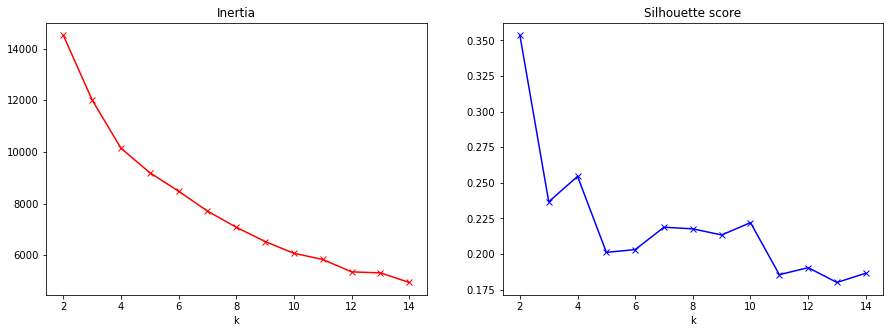

In [7]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [8]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

## Fit and classify using silhouette score

In [9]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 19 (8.33%)
Class 1 (red): 73 (32.02%)
Class 2 (cyan): 98 (42.98%)
Class 3 (orange): 38 (16.67%)


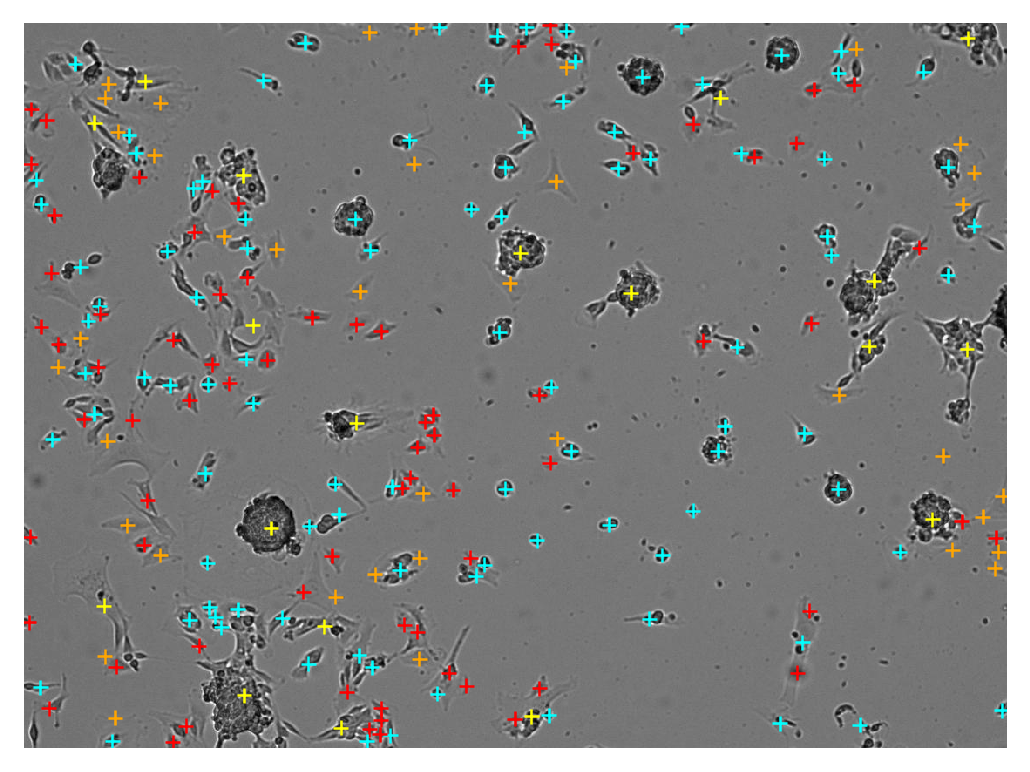

In [10]:
display_classifications(raw_image, df.index, labels)

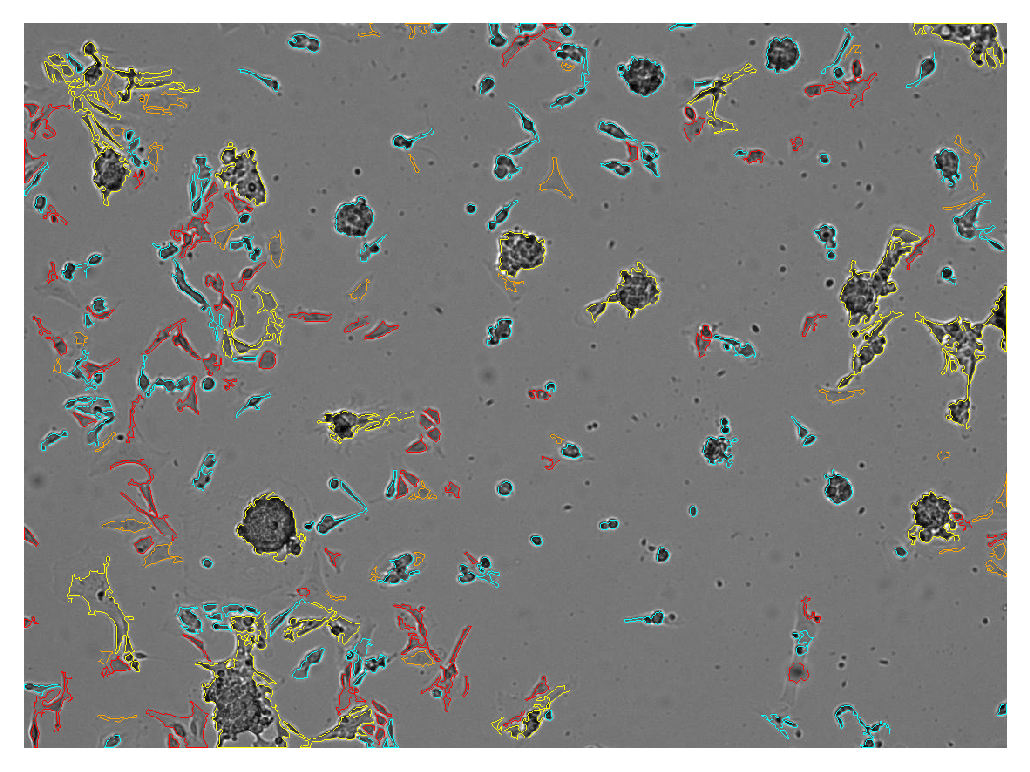

In [11]:
display_contours(raw_image, masks, labels)

Class 0, with 19 ROIs:


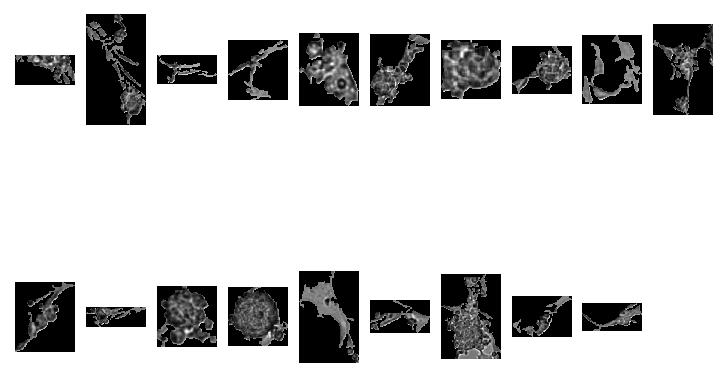

Class 1, with 73 ROIs:


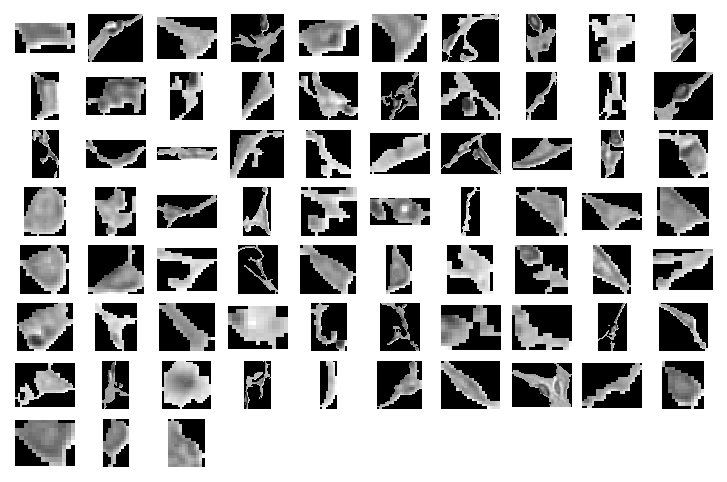

Class 2, with 98 ROIs:


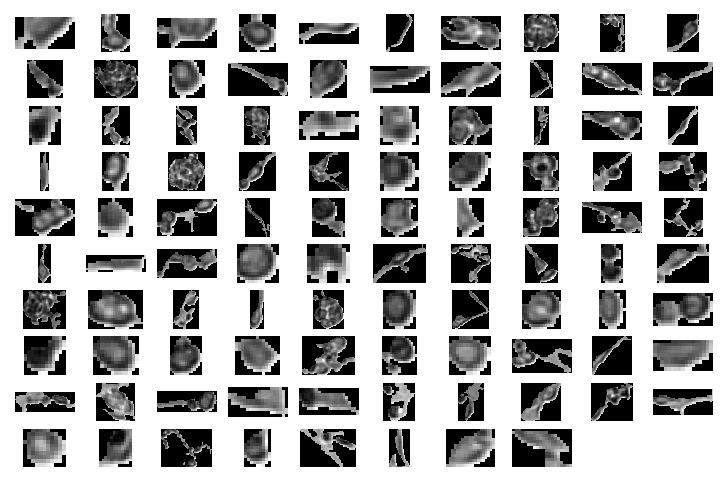

Class 3, with 38 ROIs:


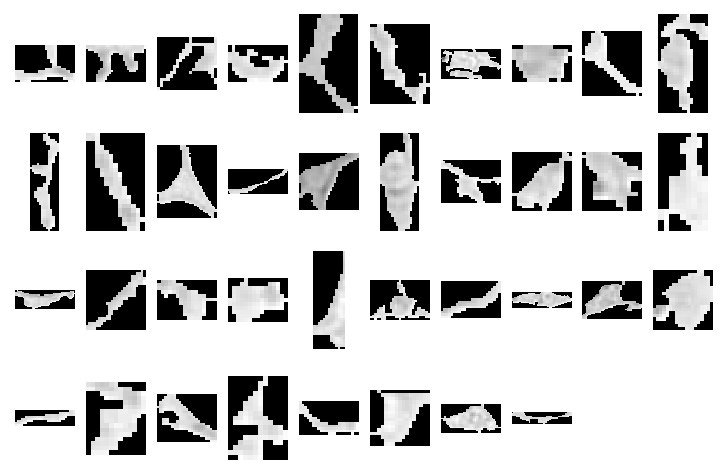

In [12]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


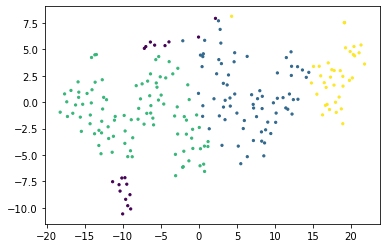

In [13]:
display_tsne(df)

# Classify cells on adherent image

In [14]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 17 (9.44%)
Class 1 (red): 57 (31.67%)
Class 2 (cyan): 67 (37.22%)
Class 3 (orange): 39 (21.67%)


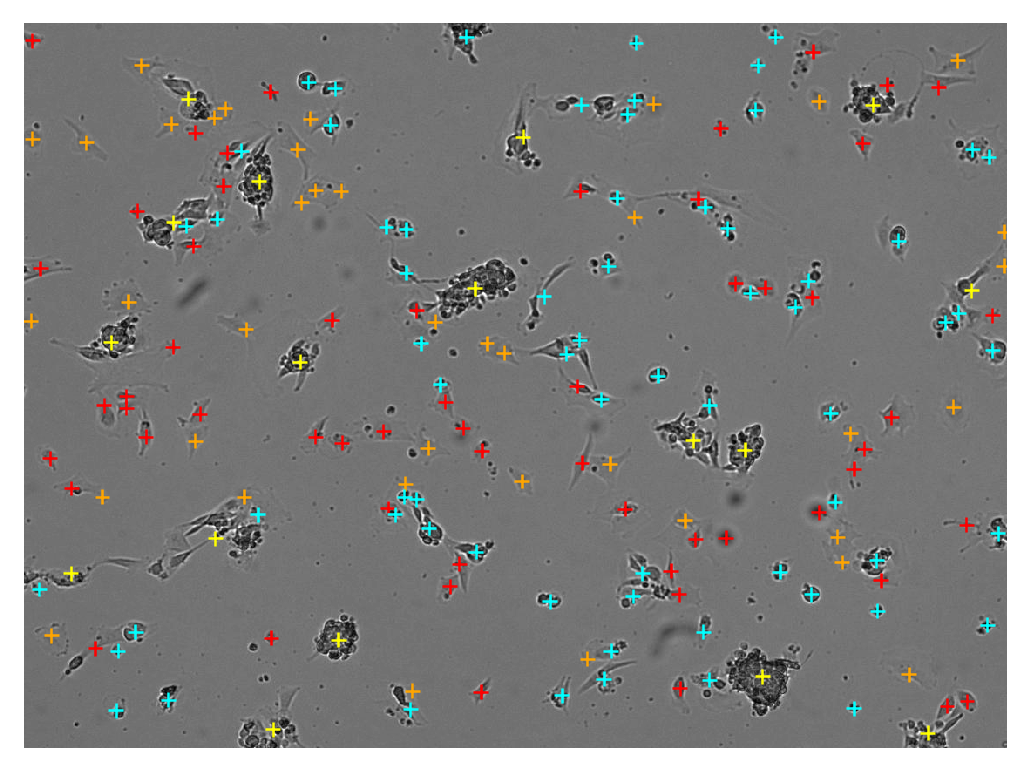

In [15]:
display_classifications(raw_image, df.index, labels)

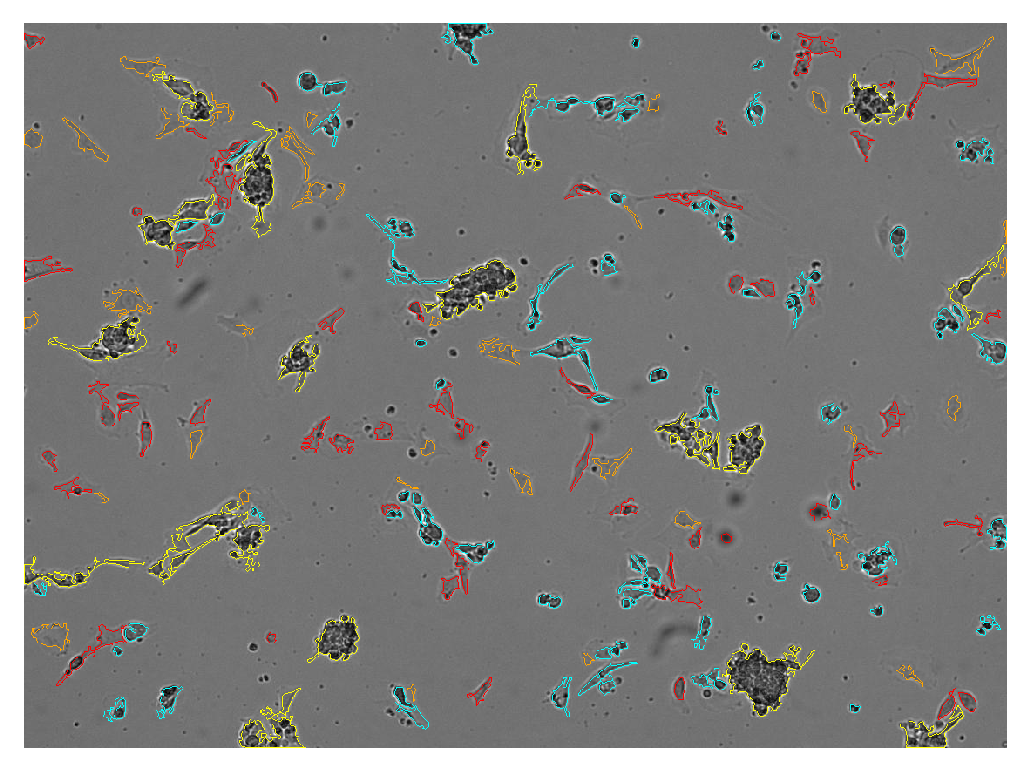

In [16]:
display_contours(raw_image, masks, labels)

Class 0, with 17 ROIs:


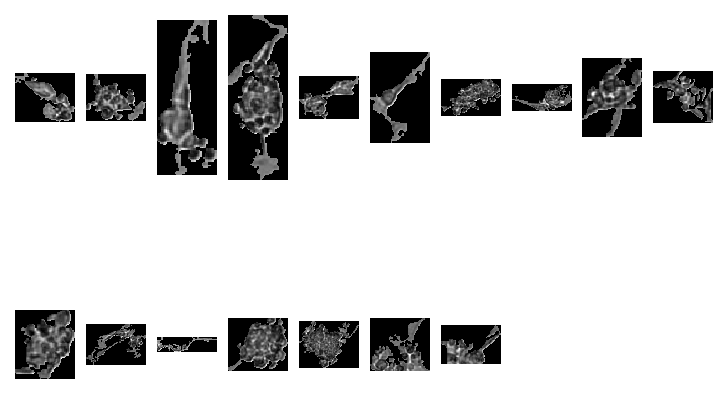

Class 1, with 57 ROIs:


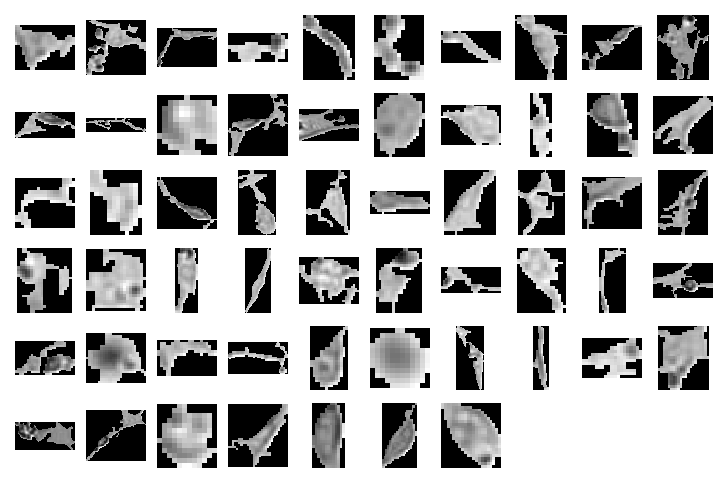

Class 2, with 67 ROIs:


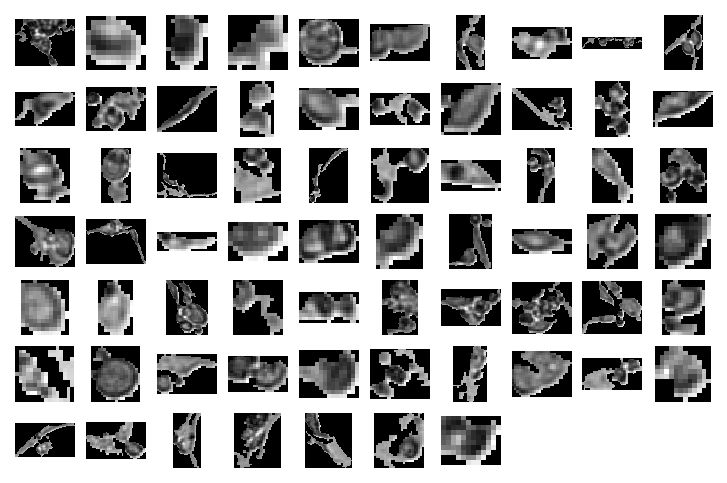

Class 3, with 39 ROIs:


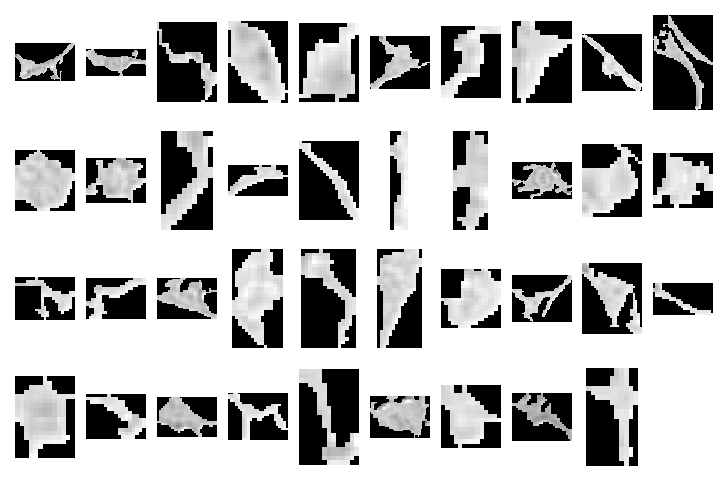

In [17]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


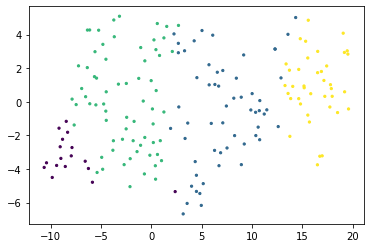

In [18]:
display_tsne(df)

# Classify cells on suspension image

In [19]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 9 (5.29%)
Class 1 (red): 72 (42.35%)
Class 2 (cyan): 74 (43.53%)
Class 3 (orange): 15 (8.82%)


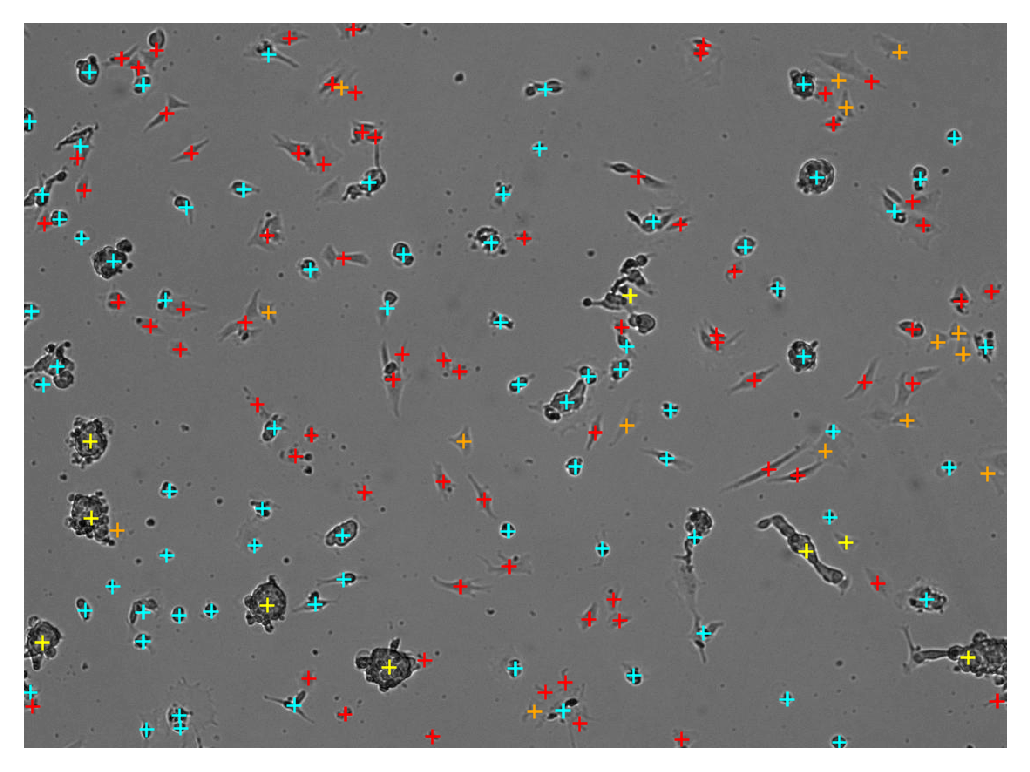

In [20]:
display_classifications(raw_image, df.index, labels)

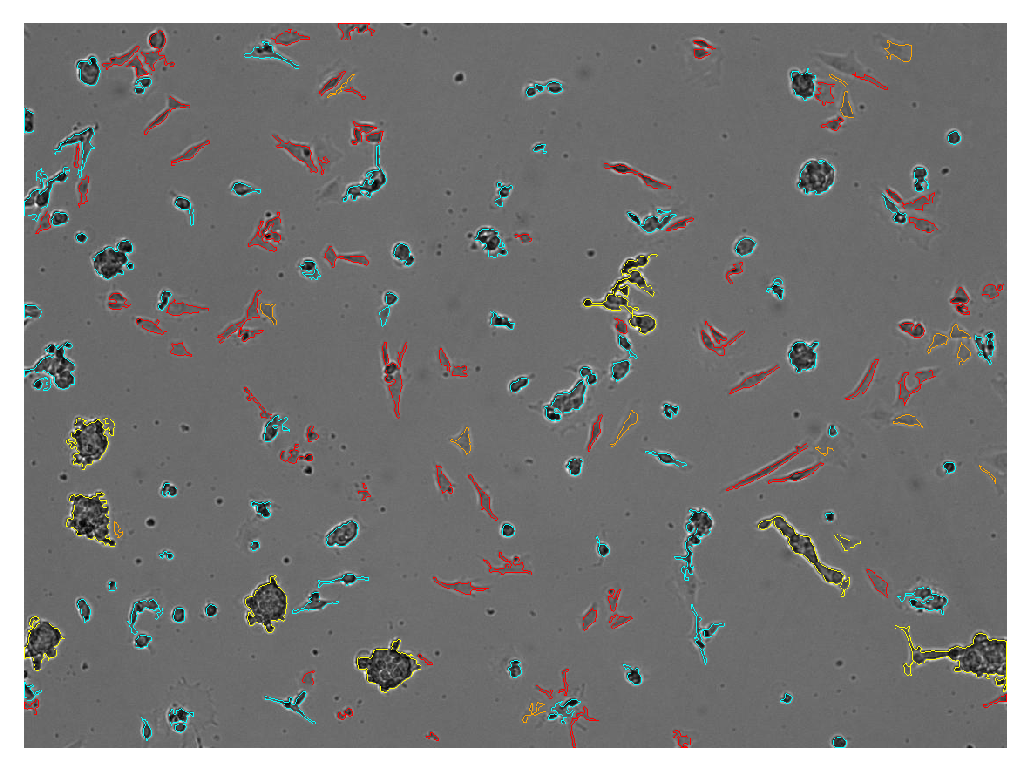

In [21]:
display_contours(raw_image, masks, labels)

Class 0, with 9 ROIs:


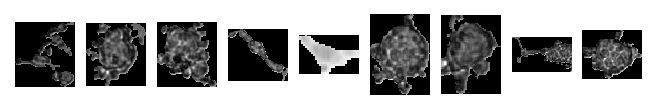

Class 1, with 72 ROIs:


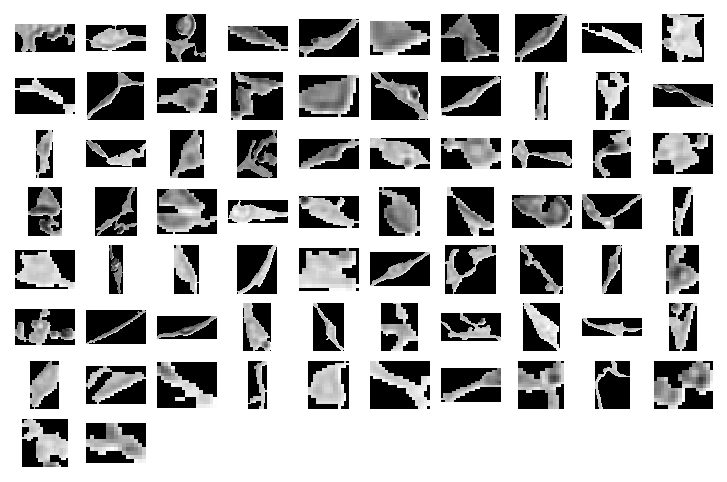

Class 2, with 74 ROIs:


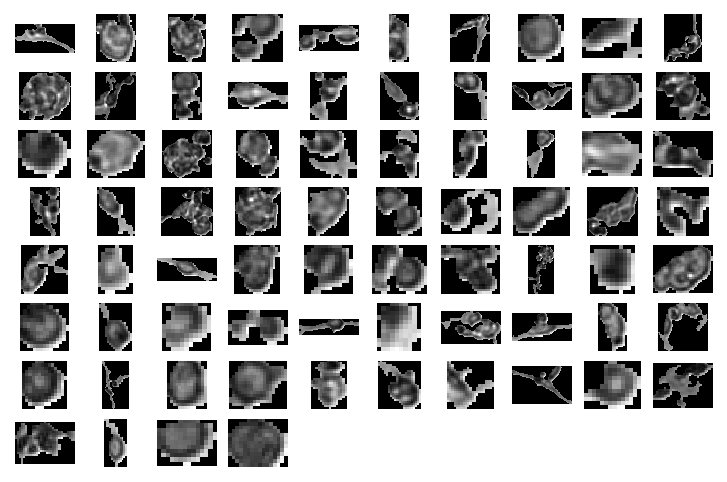

Class 3, with 15 ROIs:


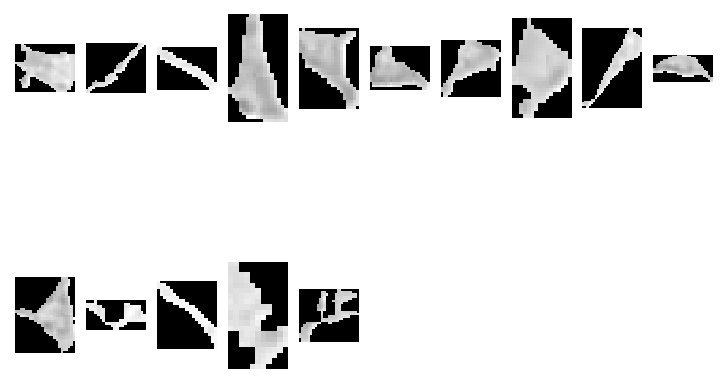

In [22]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


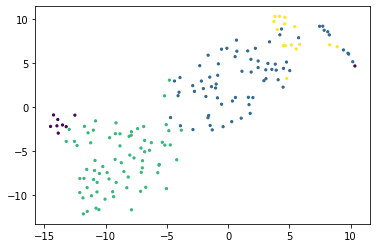

In [23]:
display_tsne(df)

# Experiment w/ multi-Otsu and Canny

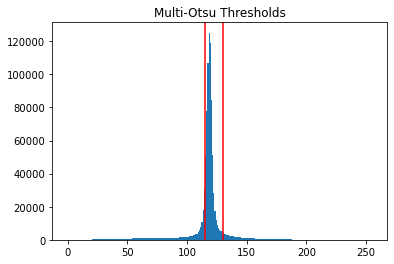

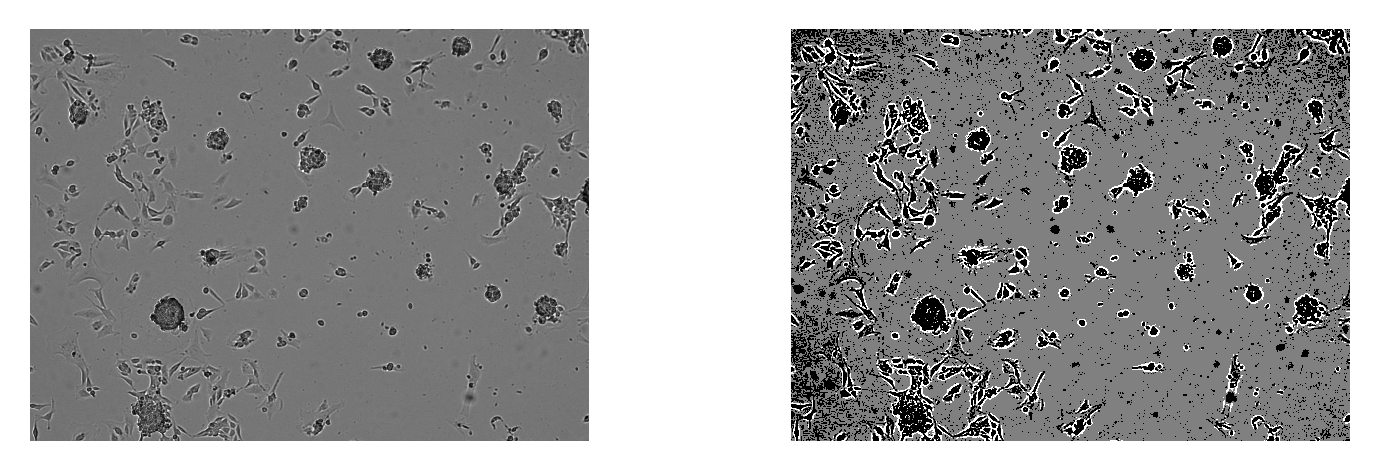

In [24]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
# blurred = apply_blur(raw_image, 5)
# enhanced = apply_contrast(blurred, 10)
# thresholds = threshold_multiotsu(enhanced)
histogram = np.histogram(raw_image.flatten(), bins=255)[0]
histogram[:97] = 0
histogram[161:] = 0
thresholds = threshold_multiotsu(hist=histogram)
multi_otsu_regions = np.digitize(raw_image, bins=thresholds)

plt.hist(raw_image.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, multi_otsu_regions], columns=2, dpi=300)

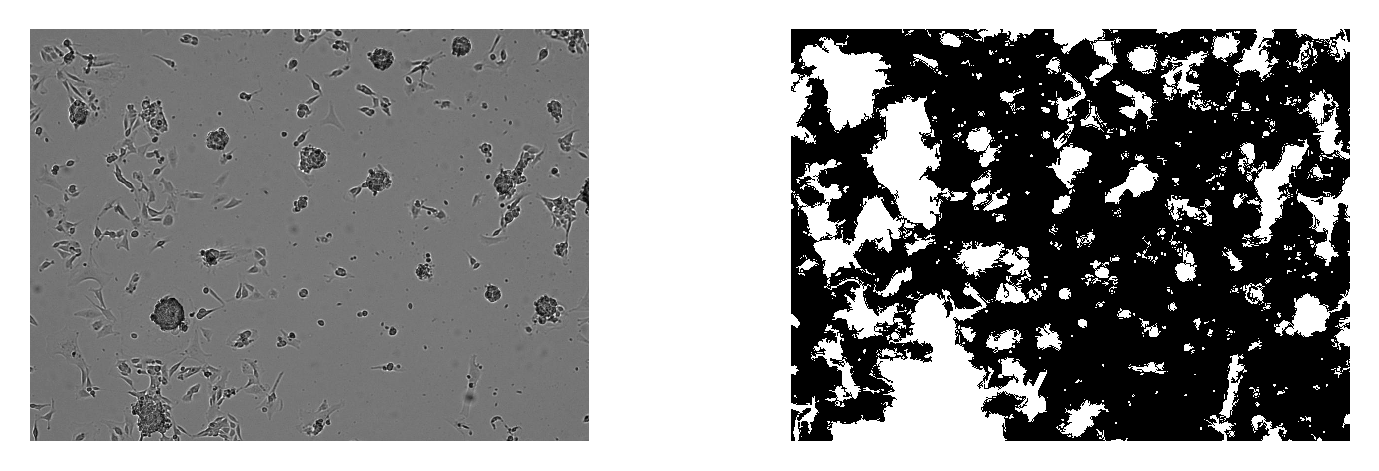

In [25]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
sharpened = apply_sharpen(raw_image)
enhanced = apply_contrast(raw_image, 2)
canny = apply_canny(enhanced, 20, 150)
filled = apply_imfill(apply_closure(canny, 2))

display_image_array([raw_image, filled], columns=2, dpi=300)